In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

In [3]:
# generate underlying causal factors
# which are the durations of the states of comp a-c
min_lenght = 1500
max_length = 2500
length = 50
comp_a_durations = np.random.randint(min_lenght, max_length, length)
comp_b_durations = np.random.randint(min_lenght, max_length, length)
comp_c_durations = np.random.randint(min_lenght, max_length, length)

In [4]:
# generate corresponding signal for causal factor of comp a
comp_a_signal = np.concatenate([[-1]*i if j%2==0 else [1]*i for j,i in enumerate(comp_a_durations)])
comp_b_signal = np.concatenate([[-1]*i if j%2==0 else [1]*i for j,i in enumerate(comp_b_durations)])
comp_c_signal = np.concatenate([[-1]*i if j%2==0 else [1]*i for j,i in enumerate(comp_c_durations)])

In [5]:
# get list of gain values for dynamic system simulation
def get_comp_signal(comp_duration):
    comp_kp_ls = [-1]
    for i in range(1, len(comp_duration)):
        comp_kp_ls.append(-1 if comp_kp_ls[i-1] == 1 else 1)
    return np.array(comp_kp_ls)
        
comp_a_kp_ls = get_comp_signal(comp_b_durations)


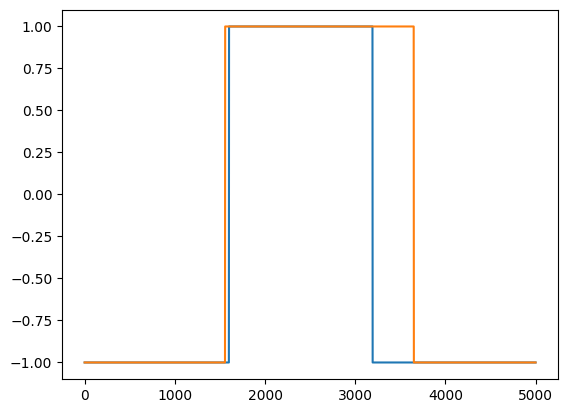

In [6]:
plt.plot(comp_a_signal[0:5000])
plt.plot(comp_b_signal[0:5000])

# Component A Signals

In [7]:
# tau * dy2/dt2 + 2*zeta*tau*dy/dt + y = Kp*u
tau = 20.0   # time constant
zeta = 0.3 # damping factor
theta = 100.0 # no time delay
du = 1.0    # change in u
taup = 50

# (3) ODE Integrator
def second_order_model(x,t, Kp):
    y = x[0]
    dydt = x[1]
    dy2dt2 = (-2.0*zeta*tau*dydt - y + Kp*du)/tau**2
    return [dydt,dy2dt2]

def first_order_model(y,t,Kp):
    u = 1
    return (-y + Kp * u)/taup

In [8]:
x0_2nd = [-1, 0]
x0_1st = [-1.1, 0]
y_2nd_ls = []
y_1st_ls = []

for Kp, tmax in zip(comp_a_kp_ls, comp_a_durations):
    t = np.linspace(0, tmax, tmax)
    x_2nd = odeint(second_order_model, x0_2nd, t, (Kp,))
    y_2nd = x_2nd[:, 0]
    y_2nd_ls.append(y_2nd)
    x0_2nd = list(x_2nd[-1, :])
    
    x_1st = odeint(first_order_model, x0_1st, t, (Kp-.1,))
    y_1st = x_1st[:, 0]
    y_1st_ls.append(y_1st)
    x0_1st = list(x_1st[-1, :])

In [9]:
sig_1 = comp_a_signal
sig_2 = np.concatenate(y_2nd_ls)
sig_3 = np.concatenate(y_1st_ls)

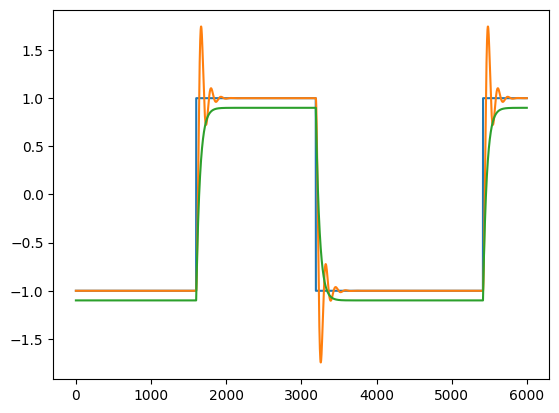

In [10]:
plt.figure(1)
plt.plot(sig_1[0:6000])
plt.plot(sig_2[0:6000])
plt.plot(sig_3[0:6000])

# Component B Signals

In [11]:
min_len = min([len(sig) for sig in [comp_a_signal, comp_b_signal]])
min_len

100531

In [12]:
df = pd.DataFrame(dict(comp_a=comp_a_signal[:min_len], comp_b=comp_b_signal[:min_len]))

In [13]:
t = np.linspace(0, min_len, min_len)
# sig_4 = (comp_b_signal+1) * np.sin(2*np.pi*1/500*t)
sig_4 = comp_b_signal
sig_5 = df.comp_b.cumsum()/df.comp_b.cumsum().max()
sig_6 = sig_5 + .5*np.sin(2*np.pi * 1/1000 * t)

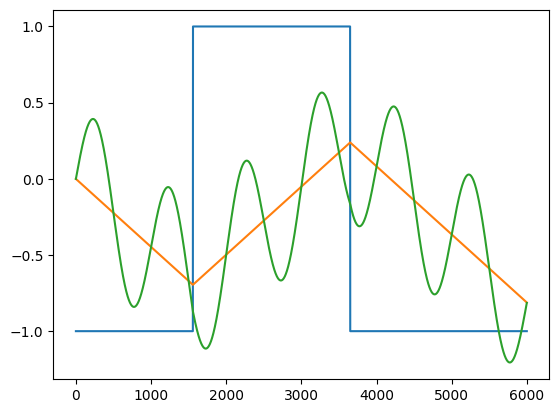

In [14]:
plt.plot(sig_4[0:6000])
plt.plot(sig_5[0:6000])
plt.plot(sig_6[0:6000])

In [15]:
# Modify sigs for cross influence

In [16]:
sig_1 = sig_1[:min_len] + .3*sig_5[:min_len]
sig_4 = sig_4[:min_len] + .1*sig_1[:min_len]

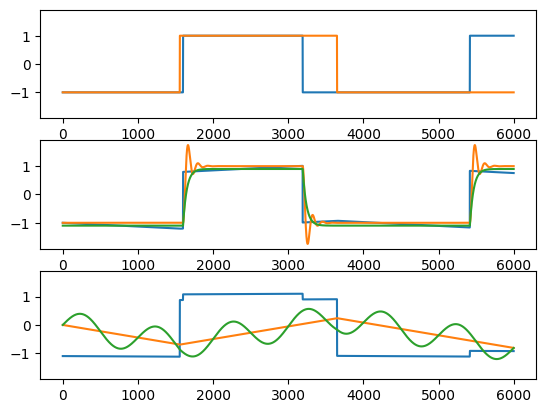

In [17]:
start_idx=0
end_idx=6000
fig, axs = plt.subplots(3, 1, sharey='all')
axs[0].plot(df[start_idx:end_idx])
axs[1].plot(sig_1[start_idx:end_idx])
axs[1].plot(sig_2[start_idx:end_idx])
axs[1].plot(sig_3[start_idx:end_idx])
axs[2].plot(sig_4[start_idx:end_idx])
axs[2].plot(sig_5[start_idx:end_idx])
axs[2].plot(sig_6[start_idx:end_idx])
# axs[1, 0].plot(sample_x_hat[index, :, :].detach().numpy().T)
# axs[0, 1].plot(sample_y[index, :, :].detach().numpy().T)
# axs[1, 1].plot(sample_y_hat[index, :, :].detach().numpy().T)
fig.show()

In [19]:
import pandas as pd
df = pd.DataFrame(dict(sig_1=sig_1[:min_len],
                       sig_2=sig_2[:min_len],
                       sig_3=sig_3[:min_len],
                       sig_4=sig_4[:min_len],
                       sig_5=sig_5[:min_len],
                       sig_6=sig_6[:min_len],
                       # sig_7=sig_7,
                      ))
TRAIN_DATA_PATH = 'data/trainin_data.csv'
df.to_csv(TRAIN_DATA_PATH, index=False)